### Imports

In [18]:
import os
import random
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import pickle

import torch
from torch import nn
from torch import utils
from torch.utils.data import DataLoader, Dataset
from torch import optim

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms

import Levenshtein

print(torchvision.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

0.12.0


## Fix randomness

In [19]:
RANDOM_SEED = 123
loader_gen = torch.Generator()

def seed_worker(worker_id):
    """ Fix workers seed """
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

        
def config_randomness():
    """ Fix randomness of the model """
    global loader_gen
    
    # Fix random seeds
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    
    # Fix data loader randomness
    loader_gen = torch.Generator()
    loader_gen.manual_seed(RANDOM_SEED)
    
    # Fix CUDA random seed
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [20]:
class ShortTextDataset(Dataset):
    def __init__(self, data_folder: str, mapping_path: str, img_height: int, alphabet: str, color_config: str):
        self.data_folder = data_folder
        self.height = img_height
        self.color_config = color_config
        self.mapping = pd.read_csv(mapping_path, index_col=0)
        
        self.files_list = [item for item in os.listdir(data_folder)]
        self.letter_to_ind_dict = {letter: ind for ind, letter in enumerate(alphabet, 1)}
        self.letter_to_ind_dict['-'] = 0
        self.ind_to_letter_dict = {letter: ind for ind, letter in enumerate(alphabet, 1)}
        self.ind_to_letter_dict[0] = '-'
        
    def __getitem__(self, ind: int):
        try:
            img = Image.open(os.path.normpath(self.data_folder + f'/{self.mapping["path"][ind]}')).convert(self.color_config)
        except KeyError:
            return None, None
        
        # Resize image with ratio saving
        ratio = self.height / img.size[1]
        
        new_height = self.height
        new_width = int(img.size[0] * ratio)
        
        return img.resize((new_width, new_height), Image.Resampling.BILINEAR), [self.letter_to_ind_dict[letter] for letter in self.mapping['label'][ind]]
    
    def __len__(self):
        return self.mapping.shape[0]

In [21]:
train_ds = ShortTextDataset('/kaggle/input/russiancapitalizedocr/train/', 
                            mapping_path='/kaggle/input/russiancapitalizedocr/train_mapping.csv', 
                            img_height=32,
                            alphabet='АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ ',
                            color_config='RGB'
                           )

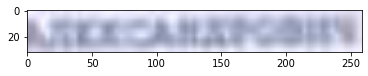

In [22]:
plt.imshow(train_ds[1][0])

(<matplotlib.image.AxesImage at 0x7f8d957eb150>, [14, 21, 8])

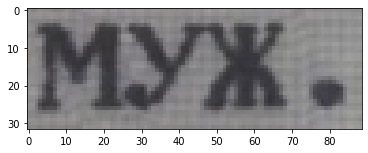

In [23]:
plt.imshow(train_ds[500][0]), train_ds[500][1]

**T** - input size

**N** - batch size

**C** - class count

## Model definition

In [24]:
class BidirectionalLSTM(nn.Module):
    """ LSTM and linear layers combination """
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()

        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.linear = nn.Linear(nHidden * 2, nOut)

    def forward(self, input_batch):
        recurrent, _ = self.rnn(input_batch)
        T, b, h = recurrent.size()        
        
        t_rec = recurrent.view(T * b, h)

        output = self.linear(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module):
    """ CRNN implementation from original paper https://arxiv.org/abs/1507.05717 """
    def __init__(self, imgH, input_channels_count, nclass, rnn_hidden_size, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'
        
        kernel_sizes_list = [3, 3, 3, 3, 3, 3, 2]
        paddings_list = [1, 1, 1, 1, 1, 1, 0]
        strides_list = [1, 1, 1, 1, 1, 1, 1]
        channels_list = [64, 128, 256, 256, 512, 512, 512]

        cnn_seq = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            """ Combinate convolutional and ReLU layers """
            nIn = input_channels_count if i == 0 else channels_list[i - 1]
            nOut = channels_list[i]
            
            cnn_seq.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, kernel_sizes_list[i], strides_list[i], paddings_list[i]))
            
            print(nIn, nOut, kernel_sizes_list[i], strides_list[i], paddings_list[i])
            
            if batchNormalization:
                cnn_seq.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn_seq.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn_seq.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn_seq.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64 (Channels, Height, Width)
        convRelu(1)
        cnn_seq.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn_seq.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn_seq.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # 512x1x16

        self.cnn_module = cnn_seq
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, rnn_hidden_size, rnn_hidden_size),
            BidirectionalLSTM(rnn_hidden_size, rnn_hidden_size, nclass + 1))

    def forward(self, img_batch):
        # Get conv features
        conv = self.cnn_module(img_batch)
        batch_size, channels_count, img_height, img_width = conv.size()
        
        assert img_height == 1, "the height of conv must be 1"
        
        conv = conv.squeeze(2)

        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # Analyze conv features with RNN
        output = self.rnn(conv)

        return output

## Train loop

In [25]:
def ctc_decode(model_answer: torch.Tensor, alphabet: str, blank_symb: int) -> list:
    """ Decodes answer of the model trained with CTC loss """
    raw_text_ans = ['-' if item == blank_symb else alphabet[item - 1] for item in model_answer]
    
    prev_rep = 0
    
    result = [raw_text_ans[0]]
    
    for cur_pos in range(1, len(raw_text_ans)):        
        if raw_text_ans[cur_pos] != raw_text_ans[prev_rep]:
            result.append(raw_text_ans[cur_pos])
            prev_rep = cur_pos        
    
    return ''.join(filter(lambda x: x != '-', result))

In [26]:
blank_symb = 0
# Check rightness of decoding algorithm
ctc_decode(torch.IntTensor([0, 1, 0, 1, 2, 3, 0, 0, 1, 2, 0, 2, 3, 1, 1, 1, 1, 0, 1, 2]), 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ ', blank_symb)

'ААБВАББВААБ'

In [27]:
tensor_transformer = transforms.ToTensor()

def to_torch_collate_fn(batch):
    """ Batch formating function """
    images = list()
    labels = list()
    
    max_width = 0
    max_label_len = 0
    
    # Convert images to Tensors and find maximum width
    for temp_image, temp_label in batch:
        tensor_image = tensor_transformer(temp_image)
        
        max_width = max(tensor_image.shape[2], max_width)
        max_label_len = max(len(temp_label), max_label_len)
        
        images.append(tensor_image)
        labels.append(temp_label)
    
    # Concatenate images
    for temp_ind in range(len(images)):
        # Resize to common size(adding 0 padding)
        mod_image = torch.zeros((images[temp_ind].shape[0], images[temp_ind].shape[1], max_width))
        mod_image[:, :, :images[temp_ind].shape[2]] = images[temp_ind]
        images[temp_ind] = mod_image.unsqueeze(0)
        
        # Add padding to the label vector
        mod_label = torch.zeros((max_label_len))
        mod_label[:len(labels[temp_ind])] = torch.LongTensor(labels[temp_ind])
        labels[temp_ind] = mod_label.unsqueeze(0)
    
    return torch.cat(images, 0), torch.cat(labels, 0)

In [28]:
def train(model, train_loader, valid_loader, optimizer, loss_func, epoch_num, scheduler, alphabet):
    loss_history = list()
    valid_history = list()
    
    plt.figure(figsize=(20, 12))
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    
    plt.title('Loss dynamic')
    
    model.to(device)
    
    for epoch_step in range(epoch_num):
        model.train()
        temp_ctc_loss = 0
        
        for step, (imgs_batch, targets_batch) in enumerate(train_loader, 1):             
            imgs_batch, targets_batch = imgs_batch.to(device), targets_batch.to(device)
            
            cur_images = list()
            cur_targets = list()
            cur_target_lengths = list()

            cur_images = imgs_batch.to(device)
            cur_targets = targets_batch.to(device)

            cur_target_lengths = torch.LongTensor([torch.count_nonzero(temp_target) for temp_target in targets_batch]).to(device)

            # Get model prediction
            logits = model(cur_images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)
            
            # Get lengths
            input_lengths = torch.LongTensor([logits.size(0)] * imgs_batch.size(0)).to(device)
            target_lengths = torch.flatten(cur_target_lengths)
            
            loss = loss_func(log_probs, cur_targets, input_lengths, cur_target_lengths)
            
            optimizer.zero_grad()
            
            loss.backward()
            optimizer.step()
            
            temp_ctc_loss += loss.item()            
        
        # Validation step
        model.eval()

        cur_epoch_lev_dist = 0

        for valid_step, (imgs_batch, targets_batch) in enumerate(valid_loader, 1):
            cur_images = imgs_batch.to(device)
            cur_targets = targets_batch.to(device)

            # Get model prediction
            logits = model(cur_images)
            log_probs = torch.nn.functional.log_softmax(logits, dim=2)

            symb_predictions = torch.argmax(log_probs, dim=2)

            # Calculate metric for every prediction in the batch
            for ind, word_tensor in enumerate(torch.transpose(symb_predictions, 0, 1), 0):
                temp_word = ctc_decode(word_tensor, alphabet, 0)
                temp_true_label = ctc_decode(cur_targets[ind].type(torch.IntTensor), alphabet, 0)

                cur_epoch_lev_dist += Levenshtein.ratio(temp_word, temp_true_label)

            # Normalization by words
            cur_epoch_lev_dist /= ind + 1
        # Normalization by the batches count
        cur_epoch_lev_dist /= valid_step

        valid_history.append(cur_epoch_lev_dist)
        
        if scheduler:
            scheduler.step()
        
        loss_history.append(temp_ctc_loss / len(train_loader))
        
        print(f'\n################################## Loss: {loss_history[-1]} Levenstein: {valid_history[-1]} ##################################')
    
    plt.plot(list(range(1, epoch_num + 1)), loss_history)
    
    return loss_history, valid_history

In [29]:
torch.cuda.empty_cache()

RANDOM_SEED = 123
config_randomness()

# Dataset and model config
img_height = 32
alphabet = 'АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ '
rnn_hid_size = 256
epoch_num = 30

train_ds = ShortTextDataset('/kaggle/input/russiancapitalizedocr/train/', 
                            mapping_path='/kaggle/input/russiancapitalizedocr/train_mapping.csv', 
                            img_height=img_height,
                            alphabet=alphabet,
                            color_config='L',
                           )

test_ds = ShortTextDataset('/kaggle/input/russiancapitalizedocr/test/', 
                            mapping_path='/kaggle/input/russiancapitalizedocr/test_mapping.csv', 
                            img_height=img_height,
                            alphabet=alphabet,
                            color_config='L'
                           )

train_loader = DataLoader(train_ds, batch_size=16, num_workers=2, shuffle=True, collate_fn=to_torch_collate_fn, worker_init_fn=seed_worker, generator=loader_gen)
valid_loader = DataLoader(test_ds, batch_size=32, num_workers=2, shuffle=False, collate_fn=to_torch_collate_fn)

channels_count = 1 if train_ds.color_config == 'L' else 3
model = CRNN(input_channels_count=channels_count, imgH=img_height, nclass=len(alphabet), rnn_hidden_size=rnn_hid_size)


# Train config
learning_rate = 0.001

loss_func = nn.CTCLoss(blank=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.2, 0.7), weight_decay=0.0001)
#scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=15)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.91)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.6)
#scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 3, 5, 7, 9, 11, 12, 14, 16, 20, 27, 35], gamma=0.86)
step_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1, 3, 5, 7, 9, 11, 14, 20, 27], gamma=0.85)
exp_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.7)

scheduler = optim.lr_scheduler.SequentialLR(optimizer, [exp_scheduler, step_scheduler], milestones=[6])

# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.CyclicLR(optimizer, learning_rate, 2 * learning_rate, step_size_up=4, mode='triangular2')

1 64 3 1 1
64 128 3 1 1
128 256 3 1 1
256 256 3 1 1
256 512 3 1 1
512 512 3 1 1
512 512 2 1 0


In [30]:
# Model initialization
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight, np.sqrt(2))
        m.bias.data.fill_(0.0)
        #print(m.weight[:3, :5, :3, :3])
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)    
    
model.apply(init_weights);


################################## Loss: 4.940561316631459 Levenstein: 0.0 ##################################

################################## Loss: 3.288588863831979 Levenstein: 0.01078318383005883 ##################################

################################## Loss: 3.1554009958549782 Levenstein: 0.04561412332253286 ##################################

################################## Loss: 3.049571911493937 Levenstein: 0.06308670712061244 ##################################

################################## Loss: 2.9305839891786927 Levenstein: 0.04997447268926745 ##################################

################################## Loss: 2.826988697052002 Levenstein: 0.06521045969165677 ##################################

################################## Loss: 2.9940411029038607 Levenstein: 0.049770019681279865 ##################################

################################## Loss: 2.7512837339330605 Levenstein: 0.04790661878771235 ##############################

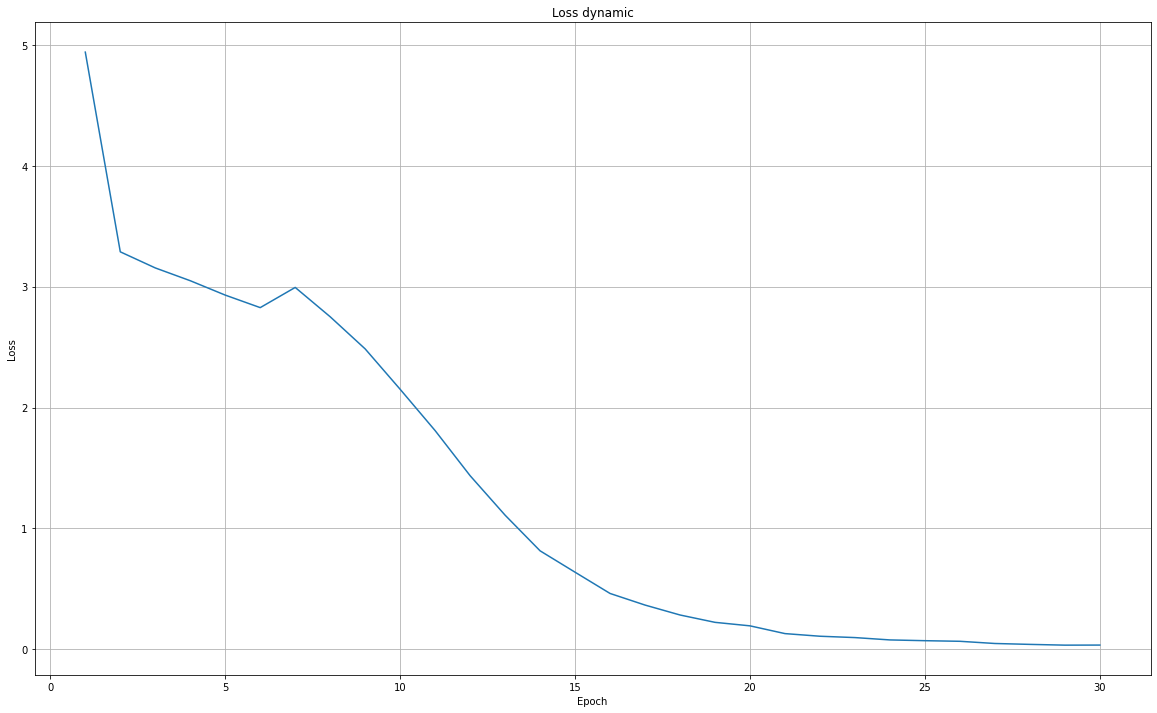

In [31]:
%%time
res = train(model, train_loader, valid_loader, optimizer, loss_func, epoch_num, scheduler, alphabet)

## Model results demonstration

In [32]:
def show_model_prediction(model, dataset):
    """ Shows model prediction for this dataset """
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, num_workers=1, shuffle=False, collate_fn=to_torch_collate_fn)
    
    img_count = len(dataset)
    
    model.eval()
    
    pred_words_list = list()
    
    for imgs_batch, _ in data_loader:
        cur_images = imgs_batch.to(device)

        # Get model prediction
        logits = model(cur_images)
        log_probs = torch.nn.functional.log_softmax(logits, dim=2)

        symb_predictions = torch.argmax(log_probs, dim=2)
        
        # Calculate metric for every prediction in the batch
        for ind, word_tensor in enumerate(torch.transpose(symb_predictions, 0, 1), 0):
            temp_word = ctc_decode(word_tensor, alphabet, 0)

            pred_words_list.append(temp_word)
    
    fig = plt.figure(figsize=(10, img_count * 3))
    rows = img_count
    
    for ind, ((img, label), pred_label) in enumerate(zip(dataset, pred_words_list), 1):
        fig.add_subplot(rows, 1, ind)

        # Show prediction
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicted: {pred_label}')

CPU times: user 1.51 s, sys: 67.4 ms, total: 1.58 s
Wall time: 1.68 s


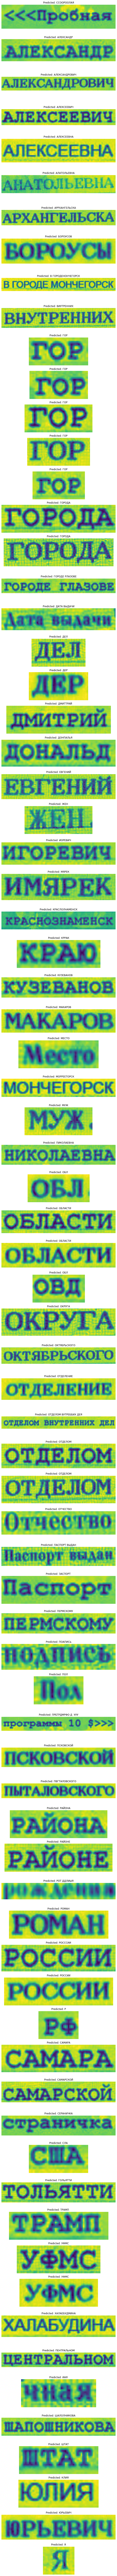

In [33]:
%%time
show_model_prediction(model.to(device), test_ds)

## Save model

In [34]:
with open('/kaggle/working/recog_model.bin', mode='wb') as file:
    pickle.dump(model, file)